#Downloads

In [1]:
!pip install pytorch_lightning jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 40.6 MB/s eta 0:00:00


In [2]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
!wandb login #YOUR WANDB TOKEN HERE

wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [4]:
# install git-lfs first
!sudo apt-get install -y git-lfs
!git lfs install

# clone
!git clone https://huggingface.co/datasets/vuihocrnd/l2-arctic-cleaned

# rename folder
!mv l2-arctic-cleaned L2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Git LFS initialized.
Cloning into 'l2-arctic-cleaned'...
remote: Enumerating objects: 3618, done.
remote: Total 3618 (delta 0), reused 0 (delta 0), pack-reused 3618 (from 1)
Receiving objects: 100% (3618/3618), 817.00 KiB | 9.84 MiB/s, done.
Resolving deltas: 100% (64/64), done.
Updating files: 100% (3484/3484), done.
Filtering content: 100% (3477/3477), 1.05 GiB | 38.45 MiB/s, done.


#Dataloader

In [1]:
import json
from torch.utils.data import Dataset
import torch, librosa, gc
import ast
from transformers import Wav2Vec2FeatureExtractor
import numpy as np


feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=16000,
    padding_value=0.0,
    padding_side="right",
    do_normalize=False,           # let HF do z-score normalization
    return_attention_mask=True   # we will pass it to the model
)

with open('vocab.json') as f:
    dict_vocab = json.load(f)


def debug_stats(name, tensor, n_samples=8):
    # overall stats
    print(f"{name}:")
    print(f"  shape: {tuple(tensor.shape)}")
    print(f"  min:   {tensor.min().item():.4f}")
    print(f"  max:   {tensor.max().item():.4f}")
    print(f"  mean:  {tensor.float().mean().item():.4f}")
    print(f"  std:   {tensor.float().std().item():.4f}")

    # sample entries
    batch_size = tensor.shape[0] if tensor.ndim > 1 else 1
    n_to_show = min(n_samples, batch_size)

    for idx in range(n_to_show):
        if tensor.ndim > 1:
            arr = tensor[idx].detach().cpu()
        else:
            arr = tensor.detach().cpu()

        n = arr.shape[0]
        if n <= 15:
            sample = arr.tolist()
        else:
            first = arr[:5].tolist()
            mid   = arr[n//2 - 2 : n//2 + 3].tolist()
            last  = arr[-5:].tolist()
            sample = first + ["..."] + mid + ["..."] + last

        print(f"  sample[{idx}]: {sample}")

    print("-" * 50)




def normalize_for_wav(w):
    # ensure finite
    w = np.nan_to_num(w, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    if len(w) == 0:
        return np.zeros(160, dtype=np.float32)
    # scale by max abs so values are in [-1,1]
    m = np.max(np.abs(w))
    if m > 0:
        w = w / m
    return w

def text_to_tensor(string_text):
    text = string_text.split(" ")
    text_list = []
    for token in text:
        token = token.strip()
        if not token:
            continue
        if token not in dict_vocab:
            print("Unknown token:", token)
        else:
            text_list.append(dict_vocab[token])
    return text_list



In [2]:

def collate_fn(batch):
    with torch.no_grad():
        waveforms, canonicals, transcripts, errors, outlens = [], [], [], [], []
        for w, c, t, e in batch:
            # w = normalize_for_wav(w)
            waveforms.append(w)
            canonicals.append(c)
            transcripts.append(t)
            errors.append(e)
            outlens.append(len(t))

        feats = feature_extractor(
            waveforms, sampling_rate=16000, return_tensors="pt", padding=True
        )


        canon_max = max(len(c) for c in canonicals) if canonicals else 0
        tran_max  = max(len(t) for t in transcripts) if transcripts else 0
        err_max   = max(len(e) for e in errors) if errors else 0

        canonicals  = [c + [70] * (canon_max - len(c)) for c in canonicals]
        transcripts = [t + [70] * (tran_max  - len(t)) for t in transcripts]
        errors      = [e + [2 ] * (err_max   - len(e)) for e in errors]

        canonicals  = torch.tensor(canonicals,  dtype=torch.long)
        transcripts = torch.tensor(transcripts, dtype=torch.long)
        errors      = torch.tensor(errors,      dtype=torch.long)
        outlens     = torch.tensor(outlens,     dtype=torch.long)


        # Debug prints______________________________________________________________________
        # debug_stats("input_values", feats.input_values)
        # debug_stats("attention_mask", feats.attention_mask)
        # debug_stats("canonicals", canonicals)
        # debug_stats("transcripts", transcripts)
        # debug_stats("errors", errors)
        # debug_stats("outlens", outlens)
        # print("waveform per-sample stds:", feats.input_values.std(dim=1))

        # # Alignment check
        # for i in range(len(batch)):
        #     x = feats.input_values[i]
        #     m = feats.attention_mask[i]

        #     # mask must be prefix of 1s then 0s
        #     m_np = m.detach().cpu().numpy()
        #     first_zero = (m_np == 0).argmax() if (m_np == 0).any() else len(m_np)
        #     cond_mask = np.all(m_np[:first_zero] == 1) and np.all(m_np[first_zero:] == 0)

        #     # padded region in x must be all 0
        #     cond_pad = torch.all(x[m == 0] == 0)

        #     aligned = bool(cond_mask and cond_pad)
        #     print(f"Sample {i} padding lined up? {aligned}")
        #_____________________________________________________________________________________

        return (
            feats.input_values,   # [B, T]
            feats.attention_mask, # [B, T]
            canonicals,
            transcripts,
            errors,
            outlens,
        )

In [3]:
class L2_Dataset(Dataset):
    def __init__(self, data):
        self.len = len(data)
        self.path = data['Label']
        self.canonical = list(data['Canonical'])
        self.transcript = list(data['Transcript'])
        self.error = list(data['Error'])

    def __getitem__(self, idx):
        wav, _ = librosa.load(f"/content/L2/train/audio/{self.path[idx]}.wav", sr=16000)
        canonical  = text_to_tensor(self.canonical[idx])
        transcript = text_to_tensor(self.transcript[idx])
        error      = ast.literal_eval(self.error[idx])
        return wav.astype(np.float32), canonical, transcript, error

    def __len__(self):
        return self.len

In [4]:
import pandas as pd
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2PreTrainedModel, Wav2Vec2Model, Wav2Vec2Config
from torch.utils.data import DataLoader
import torch
import gc
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [5]:
# Load full dataset
df = pd.read_csv("/content/L2/train/trainset.csv")
#df = df.head(300)


# Split 80/20 with shuffling
train_df, val_df = train_test_split(
    df,
    test_size=0.05,
    shuffle=False,
    random_state=42   # for reproducibility
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

#Preparing trainset for bucket batching

In [6]:
import librosa
from tqdm import tqdm

audio_dir = "/content/L2/train/audio"

lengths = []
for label in tqdm(train_df["Label"]):
    wav_path = f"{audio_dir}/{label}.wav"
    wav, _ = librosa.load(wav_path, sr=16000)
    duration = len(wav) / 16000.0   # seconds
    lengths.append(duration)

train_df["Audio Length"] = lengths

100%|██████████| 3019/3019 [00:18<00:00, 163.28it/s]


In [7]:
#AI slop that gets the job done, will simplify later

import numpy as np
import pandas as pd

def make_index_bins_div8(lengths, max_span=0.3):
    """
    lengths: 1D numpy array of audio lengths (unsorted)
    max_span: maximum allowed span for a bin (seconds)
    Returns: list of (start_idx, end_idx) pairs on the SORTED array, end_idx is exclusive.
    Ensures every non-final bin size is a multiple of 8 and >= 8.
    """
    lengths_sorted = np.sort(lengths)
    n = len(lengths_sorted)
    bins_idx = []
    i = 0

    # Greedy: at each i, choose the largest multiple-of-8 block that:
    #  - fits within max_span
    #  - leaves either zero remaining or at least 8 remaining after allocation
    while i + 8 <= n:
        valid_sizes = []
        # try multiples of 8
        for size in range(8, n - i + 1, 8):
            span = lengths_sorted[i + size - 1] - lengths_sorted[i]
            if span <= max_span:
                remainder = n - (i + size)
                # accept this size only if remainder == 0 or remainder >= 8
                if remainder == 0 or remainder >= 8:
                    valid_sizes.append(size)
                # otherwise don't accept it because it would leave <8 leftover
            else:
                # further increasing size will only increase span — stop
                break

        if not valid_sizes:
            # cannot form a divisible-by-8 block here; stop greedy binning
            break

        chosen = max(valid_sizes)  # largest valid multiple of 8
        bins_idx.append((i, i + chosen))
        i += chosen

    # final leftover bin (could be any size; if empty we don't add)
    if i < n:
        bins_idx.append((i, n))

    return bins_idx, lengths_sorted

# Build bins on train_df
lengths = train_df["Audio Length"].values
bins_idx, lengths_sorted = make_index_bins_div8(lengths, max_span=0.2)

# Map sorted positions back to original row indices
# Build a DataFrame of sorted order
sorted_order = np.argsort(lengths)  # positions of original indices in sorted order
# sorted indices -> original row indices
sorted_original_indices = train_df.index.values[sorted_order]

# Create a BinID column for original DataFrame (default -1)
bin_id_for_sorted_pos = np.full(len(lengths), -1, dtype=int)
for b, (s, e) in enumerate(bins_idx):
    bin_id_for_sorted_pos[s:e] = b

# Now map bin ids back to original df order
# bin_id_for_sorted_pos[i] is bin id for the i-th element in sorted array.
# we need to place these values at positions sorted_original_indices.
bin_id_by_original_index = np.full(len(lengths), -1, dtype=int)
bin_id_by_original_index[sorted_original_indices] = bin_id_for_sorted_pos

train_df = train_df.copy()
train_df["Length Bin ID"] = bin_id_by_original_index

# Compute counts per bin in the *final* order (bins_idx order)
from collections import OrderedDict
counts_in_order = OrderedDict()
for b, (s, e) in enumerate(bins_idx):
    counts_in_order[f"bin_{b} ({lengths_sorted[s]:.3f},{lengths_sorted[e-1]:.3f})"] = (e - s)

# HARD CHECK: every non-final bin must be divisible by 8
for b, (s, e) in enumerate(bins_idx):
    size = e - s
    # allow last bin to be any size
    if b < len(bins_idx) - 1:
        assert size % 8 == 0 and size >= 8, f"Bin {b} size {size} not multiple of 8"
    else:
        # last bin: optionally ensure >=1 (always true) — if you want to enforce >=8 uncomment next line:
        # assert size >= 8, f"Last bin too small: {size}"
        pass

# Print counts in the final (shuffled-able) order
print("Counts per bin (in bin order, start..end length shown):")
for k, v in counts_in_order.items():
    print(f"{k}\t{v}")

# train_df now has Column "Length Bin ID" with -1 for items that weren't binned (shouldn't happen).
# If you want a human-friendly range label instead:
bin_labels = []
for b, (s, e) in enumerate(bins_idx):
    label = f"[{lengths_sorted[s]:.3f}, {lengths_sorted[e-1]:.3f}]"
    bin_labels.append(label)

# map id->label (for only valid ids)
label_map = {b: bin_labels[b] for b in range(len(bin_labels))}
train_df["Length Bin Label"] = train_df["Length Bin ID"].map(label_map)

# Sanity print
print("\nBin labels (in order):")
for i, lbl in enumerate(bin_labels):
    print(i, lbl)


Counts per bin (in bin order, start..end length shown):
bin_0 (0.999,1.160)	8
bin_1 (1.160,1.330)	24
bin_2 (1.334,1.518)	40
bin_3 (1.520,1.720)	56
bin_4 (1.720,1.910)	64
bin_5 (1.914,2.110)	72
bin_6 (2.111,2.301)	96
bin_7 (2.302,2.502)	128
bin_8 (2.504,2.700)	152
bin_9 (2.700,2.900)	168
bin_10 (2.901,3.100)	184
bin_11 (3.100,3.300)	208
bin_12 (3.300,3.496)	184
bin_13 (3.499,3.697)	200
bin_14 (3.698,3.895)	224
bin_15 (3.896,4.081)	192
bin_16 (4.083,4.280)	168
bin_17 (4.280,4.475)	128
bin_18 (4.478,4.661)	112
bin_19 (4.672,4.870)	104
bin_20 (4.873,5.061)	88
bin_21 (5.062,5.261)	88
bin_22 (5.264,5.450)	64
bin_23 (5.456,5.648)	56
bin_24 (5.650,5.830)	56
bin_25 (5.838,5.990)	32
bin_26 (5.991,6.113)	24
bin_27 (6.116,6.300)	16
bin_28 (6.308,6.443)	16
bin_29 (6.454,6.650)	16
bin_30 (6.708,6.868)	8
bin_31 (6.887,7.021)	8
bin_32 (7.050,7.218)	8
bin_33 (7.232,9.347)	27

Bin labels (in order):
0 [0.999, 1.160]
1 [1.160, 1.330]
2 [1.334, 1.518]
3 [1.520, 1.720]
4 [1.720, 1.910]
5 [1.914, 2.110]
6 [

In [8]:
import numpy as np
import pandas as pd

def shuffle_bins_keep_last(df):
    df = df.copy()

    # Step 1: sort by audio length
    df = df.sort_values("Audio Length").reset_index(drop=True)

    # Step 2: shuffle within each bin
    bins = []
    for b_id, group in df.groupby("Length Bin ID", sort=False):
        group_shuffled = group.sample(frac=1, random_state=None).reset_index(drop=True)
        bins.append((b_id, group_shuffled))

    # Step 3: separate last bin
    bins_sorted = sorted(bins, key=lambda x: x[0])  # ensure bin order
    bins_to_shuffle = bins_sorted[:-1]              # all but last
    last_bin = bins_sorted[-1]                      # last one

    # Shuffle the other bins
    rng = np.random.default_rng()
    rng.shuffle(bins_to_shuffle)

    # Step 4: concatenate shuffled bins + last bin
    final_bins = bins_to_shuffle + [last_bin]
    shuffled_df = pd.concat([g for _, g in final_bins], ignore_index=True)

    return shuffled_df



In [9]:
shuffled_train_df = shuffle_bins_keep_last(train_df)

In [10]:
import random

# get unique bin IDs from the dataframe
bin_ids = shuffled_train_df["Length Bin ID"].unique().tolist()

# exclude last bin if needed
bin_ids_except_last = bin_ids[:-1]
random.shuffle(bin_ids_except_last)

bin_ids_shuffled = bin_ids_except_last + [bin_ids[-1]]

# print counts in shuffled order
print("Counts per bin in shuffled order:")
for b_id in bin_ids_shuffled:
    count = (shuffled_train_df["Length Bin ID"] == b_id).sum()
    label = shuffled_train_df.loc[
        shuffled_train_df["Length Bin ID"] == b_id, "Length Bin Label"
    ].iloc[0]
    print(f"Bin {label}: {count}")


Counts per bin in shuffled order:
Bin [4.478, 4.661]: 112
Bin [6.308, 6.443]: 16
Bin [1.334, 1.518]: 40
Bin [3.300, 3.496]: 184
Bin [3.896, 4.081]: 192
Bin [3.499, 3.697]: 200
Bin [3.698, 3.895]: 224
Bin [6.116, 6.300]: 16
Bin [6.454, 6.650]: 16
Bin [2.111, 2.301]: 96
Bin [3.100, 3.300]: 208
Bin [2.901, 3.100]: 184
Bin [5.062, 5.261]: 88
Bin [5.264, 5.450]: 64
Bin [5.838, 5.990]: 32
Bin [1.914, 2.110]: 72
Bin [5.991, 6.113]: 24
Bin [7.050, 7.218]: 8
Bin [2.504, 2.700]: 152
Bin [1.160, 1.330]: 24
Bin [5.456, 5.648]: 56
Bin [6.708, 6.868]: 8
Bin [4.672, 4.870]: 104
Bin [2.302, 2.502]: 128
Bin [5.650, 5.830]: 56
Bin [1.720, 1.910]: 64
Bin [4.083, 4.280]: 168
Bin [6.887, 7.021]: 8
Bin [4.873, 5.061]: 88
Bin [2.700, 2.900]: 168
Bin [1.520, 1.720]: 56
Bin [4.280, 4.475]: 128
Bin [0.999, 1.160]: 8
Bin [7.232, 9.347]: 27


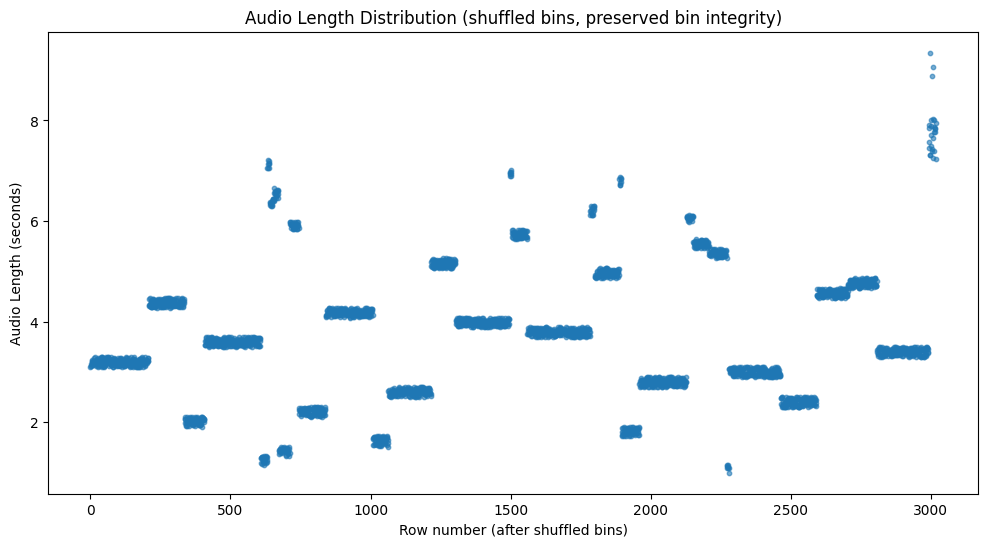

In [11]:
import matplotlib.pyplot as plt

# Scatter plot of shuffled dataframe
plt.figure(figsize=(12, 6))
plt.scatter(shuffled_train_df.index, shuffled_train_df["Audio Length"], s=10, alpha=0.6)

plt.xlabel("Row number (after shuffled bins)")
plt.ylabel("Audio Length (seconds)")
plt.title("Audio Length Distribution (shuffled bins, preserved bin integrity)")
plt.show()


In [12]:
train_df = shuffled_train_df.copy()

#Initialize Dataloader

In [13]:
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)


train_dataset = L2_Dataset(train_df )
val_dataset   = L2_Dataset(val_df)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,   # usually no shuffle for validation
    collate_fn=collate_fn
)

In [14]:
batch = next(iter(train_loader))

In [15]:
from collections import Counter

def count_word_freq(df, column="Transcript"):
    counter = Counter()
    for text in df[column]:
        tokens = text.split()
        counter.update(tokens)
    return counter

# Count frequencies in train + val
train_counts = count_word_freq(train_df, "Transcript")
val_counts   = count_word_freq(val_df, "Transcript")

# Merge if you want overall
all_counts = train_counts + val_counts

# Show top 20 most common words
print("Top 28 transcript tokens:")
for word, freq in all_counts.most_common(28):
    print(f"{word:15s} {freq}")


Top 28 transcript tokens:
AH              9398
N               6308
IH              6078
S               5975
T               5920
D               5670
IY              5131
L               3802
R               3698
M               3161
EH              3084
W               2997
HH              2870
AE              2804
K               2676
F               2518
AO              2361
ER              2151
B               2014
UW              1886
P               1880
AY              1879
EY              1864
Z               1802
V               1782
DH              1554
AA              1495
OW              1407


#Model

In [16]:
from transformers import Wav2Vec2Config, Wav2Vec2Model
import torch
import torch.nn.functional as F
import torch.nn as nn
from functools import reduce
import operator
import pytorch_lightning as pl

from jiwer import wer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from torchmetrics import Accuracy, Precision, Recall, F1Score

In [17]:

def downsample_attention_mask(attention_mask: torch.Tensor, wav2vec2_model) -> torch.Tensor:
    # Compute total downsample factor from convolution strides
    downsample_factor = 1
    for s in wav2vec2_model.config.conv_stride:
        downsample_factor *= s

    # Add channel dim for pooling
    mask_out = attention_mask[:, None, :].float()  # (B, 1, L_in)

    # Max-pool to keep padded positions as 0
    mask_out = F.max_pool1d(
        mask_out,
        kernel_size=downsample_factor,
        stride=downsample_factor,
        ceil_mode=True
    )

    return mask_out.squeeze(1).long()  # (B, L_out)

In [18]:
class RLIU_Custom(nn.Module):
  def __init__(self, wav2vec2_name=None):
        super().__init__()

        # load config & model
        config        = Wav2Vec2Config.from_pretrained(wav2vec2_name)
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(wav2vec2_name, config=config)

        # CTC Branch
        self.phone_classifier    = nn.Linear(1024, 70)

        # Error Branch
        self.canonical_embedding = nn.Embedding(71, 1024, 70)
        self.compare_attention = nn.MultiheadAttention(embed_dim=1024, num_heads=16, dropout=0.2, batch_first=True)
        self.error_classifier = nn.Sequential(
            nn.Linear(1024*2, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 2)
        )

  def freeze_feature_extractor(self):
        for param in self.wav2vec2.feature_extractor.parameters():
            param.requires_grad = False

  def forward(self, waveform, canonical, attention_mask = None):
    #W2v2 & embedding
    wavvec_out = self.wav2vec2(
            waveform,
            attention_mask=attention_mask,
            return_dict=True
        ).last_hidden_state

    canonical_pad_mask = (canonical != 70).long()
    canonical_embedded = self.canonical_embedding(canonical)

    mask_out = downsample_attention_mask(attention_mask, self.wav2vec2)

    #Force matching canonical mask shape______________________________
    B, T_w, _ = wavvec_out.shape  # wav2vec2 output length

    # Ensure exact match
    if mask_out.size(1) > T_w:
        mask_out = mask_out[:, :T_w]
    elif mask_out.size(1) < T_w:
        pad_len = T_w - mask_out.size(1)
        mask_out = F.pad(mask_out, (0, pad_len), value=0)

    # print("Mask shape: ",mask_out.shape)
    # print("W2v_out shape: ",wavvec_out.shape)

    key_mask = mask_out == 0
    #______________________________________________________


    #CTC branch_________________________________________________________________________
    B, T1, C = wavvec_out.shape
    logits = self.phone_classifier(wavvec_out)
    if attention_mask is not None:
      raw_lengths = attention_mask.sum(dim=1)             # [B], number of real audio samples
      input_lengths = torch.floor(raw_lengths.float() * T1 / attention_mask.shape[1]).long()
    else:
      input_lengths = torch.full((B,), T1, dtype=torch.long, device=wavvec_out.device)
    #___________________________________________________________________________________



    #Error classifier branch___________________________________________________
    if canonical.ndim == 2:
        canonical = canonical.unsqueeze(0)
    if wavvec_out.ndim == 2:
        wavvec_out = wavvec_out.unsqueeze(0)

    comparator, _ = self.compare_attention(canonical_embedded, wavvec_out, wavvec_out, key_padding_mask=key_mask)
    #print("Comparator shape: ",comparator.shape)
    comparator = comparator * canonical_pad_mask.unsqueeze(-1)
    # print("Comparator shape unsqueezed: ",comparator.shape)
    #combined = canonical_embedded - comparator  # [B, T2, 768]
    combined = torch.cat([canonical_embedded, comparator], dim=-1)  # [B, T2, 1536]
    predicted_error = self.error_classifier(combined)
    #__________________________________________________________________________

    return logits, input_lengths, predicted_error





In [19]:

#definitely not vibe code
class Lightning(pl.LightningModule):
    def __init__(self, lw_error = 0.5, lw_ctc =0.5, class_bias = 2.0,
                 w2v_lr                 = 3e-5,
                 classifier_lr          = 1e-3,
                 canonical_embedding_lr = 1e-4,
                 error_attention_lr     = 1e-4,
                 error_classifier_lr    = 1e-4,
                 wav2vec2_type="facebook/wav2vec2-base-100h"):
        super().__init__()

        self.model = RLIU_Custom(wav2vec2_name=wav2vec2_type)

        for param in self.model.wav2vec2.feature_extractor.parameters():
            param.requires_grad = False
        self.model.wav2vec2.feature_extractor.eval()

        self.ctc_loss = nn.CTCLoss(blank=69)
        self.nll_loss = nn.NLLLoss(ignore_index = 2,weight=torch.tensor([class_bias, 1.0]))

        self.w2v_lr = w2v_lr
        self.classifier_lr = classifier_lr
        self.lw_error = lw_error
        self.lw_ctc = lw_ctc

        # Metrics: single object per metric type, returns tensor [2] for classes {0,1}
        self.prec = Precision(task="multiclass", num_classes=2, average=None)
        self.rec  = Recall(task="multiclass", num_classes=2, average=None)
        self.f1   = F1Score(task="multiclass", num_classes=2, average=None)

    def forward(self, waveform, canonical, attention_mask):
        return self.model(waveform, canonical, attention_mask)

    def training_step(self, train_batch, batch_idx):
        waveform, attention_mask, canonical, transcript, errors, _ = train_batch
        logits, input_lengths, predicted_error = self(waveform, canonical, attention_mask)

        #CTC branch_________________________________________________________________________
        #apply softmax to logits
        log_probs = F.log_softmax(logits, dim=-1).transpose(0, 1)  # [T1, B, V]

        # targets and lengths
        target_lengths = (transcript != 70).sum(dim=1).long()  # [B]
        targets = transcript[transcript != 70]                 # flatten

        loss_ctc = self.ctc_loss(log_probs, targets, input_lengths, target_lengths)
        #___________________________________________________________________________________



        #Error classifier branch_______________________________________________________
        predicted_error = F.log_softmax(predicted_error, dim = -1)
        loss_error = self.nll_loss(predicted_error.reshape(-1, 2), errors.reshape(-1))
        #______________________________________________________________________________



        loss = loss_error * self.lw_error + loss_ctc * self.lw_ctc


        # ------------------- DEBUG CHECKS -------------------
        # probability mass in blank token (id=69)
        blank_mass = torch.exp(log_probs[..., 69]).mean().item()
        if self.global_step % 20 == 0:
            B, T1, V = logits.shape
            print(f"Step {self.global_step} | Avg blank prob: {blank_mass:.4f}")
            print("T1 (frames):", T1)
            print("Target lens:", target_lengths.tolist())
            print("Input lens:", input_lengths.tolist())

            # inspect probability distribution for the first sample (mid-frame)
            probs = torch.softmax(logits[0], dim=-1)  # [T1, V]
            mid_t = probs.shape[0] // 2
            topk = torch.topk(probs[mid_t], 5, dim=-1)
            print("Top5 probs at frame", mid_t, ":",
                  topk.indices.tolist(), topk.values.tolist())

            print("Current CTC loss: ",loss_ctc)
            print("Current NLL loss: ",loss_error)
            print("Current overall loss: ",loss)
            print("-" * 80)
        # -----------------------------------------------------

        self.log("train_loss_ctc",    loss_ctc,   prog_bar=True, on_step=True, on_epoch=True)
        self.log("train_loss_error",  loss_error, prog_bar=True, on_step=True, on_epoch=True)
        self.log("train_loss_overall",loss,       prog_bar=True, on_step=True, on_epoch=True)
        return loss


    def validation_step(self, batch, batch_idx):
        waveform, attention_mask, canonical, transcript, errors, _ = batch
        logits, input_lengths, predicted_error = self(waveform, canonical, attention_mask)

        #CTC branch_________________________________________________________________________
        log_probs_ctc = F.log_softmax(logits, dim=-1).transpose(0, 1)  # [T, B, V]
        # targets and lengths
        target_lengths  = (transcript != 70).sum(dim=1).long()
        targets         = transcript[transcript != 70]

        loss_ctc = self.ctc_loss(log_probs_ctc, targets, input_lengths, target_lengths) #LOSS

        # decode predictions
        collapsed_preds = self.greedy_decode(log_probs_ctc, blank_id=69)

        # collapse transcripts (remove pads/blanks)
        target_seqs = [[token.item() for token in t if token.item() != 69] for t in transcript]

        # inspection
        print("Prediction_Transcript[0]:", collapsed_preds[0])
        print("Target_Transcript[0]:    ", target_seqs[0])

        # WER
        avg_wer = self.compute_wer(collapsed_preds, target_seqs)
        #___________________________________________________________________________________





        #Error classifier branch__________________________________________________________________
        # NLL loss
        log_probs_error = F.log_softmax(predicted_error, dim=-1)
        loss_error = self.nll_loss(log_probs_error.reshape(-1, 2), errors.reshape(-1)) #LOSS

        # Predictions (argmax)
        preds = log_probs_error.argmax(dim=-1)  # [B, T]

        # Mask out padding for metrics
        mask = errors != 2
        y_true = errors[mask]
        y_pred = preds[mask]

        # Update metrics
        self.prec.update(y_pred, y_true)
        self.rec.update(y_pred, y_true)
        self.f1.update(y_pred, y_true)

        # Always print debug info
        for b in range(preds.size(0)):
            pred_vals = preds[b][errors[b] != 2].tolist()
            target_vals = errors[b][errors[b] != 2].tolist()

            # Softmax probabilities per class
            probs = F.softmax(predicted_error[b], dim=-1)  # [T, 2]
            probs = probs[errors[b] != 2]  # mask padding

            zero_chance = [round(x, 3) for x in probs[:, 0].detach().cpu().tolist()]
            one_chance  = [round(x, 3) for x in probs[:, 1].detach().cpu().tolist()]

            print("\n")
            print(f"[0 chance] {zero_chance}")
            print(f"[1 chance] {one_chance}")
            print(f"[Pred]   {pred_vals}")
            print(f"[Target] {target_vals}")
        print("-" * 60)
        #_________________________________________________________________________________________

        loss = loss_error * self.lw_error + loss_ctc * self.lw_ctc

        self.log("val_loss_overall", loss,     prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_loss_error",   loss_error, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_loss_ctc",     loss_ctc, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_wer",          avg_wer,  prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def on_validation_epoch_end(self):
      # Compute + log metrics
      p = self.prec.compute()
      r = self.rec.compute()
      f = self.f1.compute()
      self.log("val_precision_0", p[0])
      self.log("val_precision_1", p[1])
      self.log("val_recall_0", r[0])
      self.log("val_recall_1", r[1])
      self.log("val_f1_0", f[0])
      self.log("val_f1_1", f[1])

      print(f"[Class 0] Precision={p[0]:.4f}, Recall={r[0]:.4f}, F1={f[0]:.4f}")
      print(f"[Class 1] Precision={p[1]:.4f}, Recall={r[1]:.4f}, F1={f[1]:.4f}")
      self.prec.reset(); self.rec.reset(); self.f1.reset()


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW([
            {"params": self.model.wav2vec2.parameters(), "lr": self.w2v_lr},
            {"params": self.model.phone_classifier.parameters(), "lr": self.classifier_lr},
            {"params": self.model.canonical_embedding.parameters(), "lr": 1e-4},
            {"params": self.model.compare_attention.parameters(), "lr": 1e-4},
            {"params": self.model.error_classifier.parameters(), "lr": 1e-4},
        ], weight_decay=1e-2)

        #Will add scheduler later

        return optimizer





    #Computing logic, no need to care, just need to know that they do ... stuff, like plug n play library shit

    def greedy_decode(self, log_probs, blank_id=69):
      """
      Greedy decoding with collapse of repeats and removal of blanks.
      Args:
          log_probs: [T, B, V] tensor of log probabilities
          blank_id: index for the blank token
      Returns:
          List[List[int]]: collapsed prediction sequences
      """
      pred_ids = log_probs.argmax(dim=-1).transpose(0, 1)  # [B, T]
      collapsed_preds = []
      for seq in pred_ids:
          collapsed = []
          prev = None
          for token in seq.tolist():
              if token != prev and token != blank_id:
                  collapsed.append(token)
              prev = token
          collapsed_preds.append(collapsed)
      return collapsed_preds


    def compute_wer(self, preds, targets):
        """
        Compute average WER between predicted and target sequences.
        Args:
            preds: list of lists of predicted token IDs
            targets: list of lists of target token IDs
        Returns:
            float: average WER
        """
        pred_strs   = [" ".join(map(str, p)) for p in preds]
        target_strs = [" ".join(map(str, t)) for t in targets]

        total_wer = 0.0
        for pred, tgt in zip(pred_strs, target_strs):
            total_wer += wer(tgt, pred)
        return total_wer / len(pred_strs)


In [20]:
from google.colab import userdata
from huggingface_hub import login
from datasets import load_dataset


try:
    hf_token = userdata.get('pronunciation_test')
except userdata.SecretNotFoundError:
    print("Secret 'pronunciation' not found.")
    exit()

# 2. Đăng nhập vào Hugging Face Hub
# Code sẽ dùng token bạn cung cấp để xác thực
login(token=hf_token)

In [ ]:
!huggingface-cli login #YOUR HUGGINGFACE TOKEN HERE

In [ ]:
from huggingface_hub import hf_hub_download

ckpt_path = hf_hub_download(
    repo_id="MinhLe999/BUCKETED_TIMIT_CTC_KoelLabs",
    filename="BUCKETED_Koellabs_TIMIT_CTC.ckpt",
    repo_type="model",
    local_dir="/content"
)

print("Checkpoint downloaded to:", ckpt_path)


In [ ]:

# model = Lightning(
#     lw_error = 0.8, lw_ctc =0.2,
#     class_bias             = 3.0,
#     w2v_lr                 = 1e-6,
#     classifier_lr          = 5e-4,
#     canonical_embedding_lr = 1e-5,
#     error_attention_lr     = 1e-5,
#     error_classifier_lr    = 1e-5,
#     wav2vec2_type="KoelLabs/xlsr-english-01"
# )

# # 2. Instantiate the actual new model inside (if you want direct access)
# new_model = model.model   # this is your RLIU_Custom


# old_ckpt_path = "/content/BUCKETED_Koellabs_TIMIT_CTC.ckpt"
# # 3. Load the old checkpoint and map weights
# ckpt = torch.load(old_ckpt_path, map_location="cpu")
# state_dict = ckpt["state_dict"]

# new_state_dict = {}
# for k, v in state_dict.items():
#     # remove "model." prefix if present
#     new_key = k
#     if new_key.startswith("model."):
#         new_key = new_key[len("model."):]
#     # remap classifier → phone_classifier
#     if new_key.startswith("classifier"):
#         new_key = new_key.replace("classifier", "phone_classifier", 1)
#     new_state_dict[new_key] = v

# missing, unexpected = new_model.load_state_dict(new_state_dict, strict=False)
# print("Missing:", missing)
# print("Unexpected:", unexpected)






# # WandB setup
# wandb_logger = WandbLogger(
#     project="TestRLIU1",
#     entity="vuihoc",
#     name="full-bucket-koelabs-1"
# )

# checkpoint_callback = ModelCheckpoint(
#     monitor="val_wer",
#     mode="min",
#     save_top_k=1,
#     filename="best-checkpoint"
# )

# # Trainer
# trainer = pl.Trainer(
#     precision=32,
#     max_epochs=5,
#     accelerator="gpu", devices=1,
#     logger=wandb_logger,
#     callbacks=[checkpoint_callback],
#     log_every_n_steps=10
# )



# import gc
# gc.collect()

In [24]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import gc

# --- 1. Instantiate your Lightning model ---
model = Lightning(
    lw_error=0.8, lw_ctc=0.2,
    class_bias=3.0,
    w2v_lr=1e-6,
    classifier_lr=5e-4,
    canonical_embedding_lr=1e-5,
    error_attention_lr=1e-5,
    error_classifier_lr=1e-5,
    wav2vec2_type="KoelLabs/xlsr-english-01"
)

# --- 2. Load checkpoint & slim down ---
old_ckpt_path = "/content/BUCKETED_Koellabs_TIMIT_CTC.ckpt"

# load checkpoint dict but throw away everything except state_dict
ckpt = torch.load(old_ckpt_path, map_location="cpu")
state_dict = ckpt.get("state_dict", ckpt)  # support both Lightning + raw state_dict
del ckpt
gc.collect()

# --- 3. Remap keys ---
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k
    if new_key.startswith("model."):
        new_key = new_key[len("model."):]
    if new_key.startswith("classifier"):
        new_key = new_key.replace("classifier", "phone_classifier", 1)
    new_state_dict[new_key] = v

missing, unexpected = model.model.load_state_dict(new_state_dict, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# free memory
del state_dict, new_state_dict
gc.collect()

# --- 4. WandB setup ---
wandb_logger = WandbLogger(
    project="TestRLIU1",
    entity="vuihoc",
    name="full-bucket-koelabs-1"
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_wer",
    mode="min",
    save_top_k=1,
    filename="best-checkpoint"
)

# --- 5. Trainer ---
trainer = pl.Trainer(
    precision=32,
    max_epochs=5,
    accelerator="gpu", devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
    log_every_n_steps=10
)

# optional: free CUDA memory right before training
torch.cuda.empty_cache()
gc.collect()


Missing keys: ['canonical_embedding.weight', 'compare_attention.in_proj_weight', 'compare_attention.in_proj_bias', 'compare_attention.out_proj.weight', 'compare_attention.out_proj.bias', 'error_classifier.0.weight', 'error_classifier.0.bias', 'error_classifier.3.weight', 'error_classifier.3.bias', 'error_classifier.5.weight', 'error_classifier.5.bias']
Unexpected keys: []


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


90

In [25]:
trainer.fit(model, train_loader, val_loader)

wandb: Currently logged in as: minhworkmail03 (minhworkmail03-h-c-vi-n-c-ng-ngh-b-u-ch-nh-vi-n-th-ng) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type                | Params | Mode 
---------------------------------------------------------
0 | model    | RLIU_Custom         | 320 M  | train
1 | ctc_loss | CTCLoss             | 0      | train
2 | nll_loss | NLLLoss             | 0      | train
3 | prec     | MulticlassPrecision | 0      | train
4 | rec      | MulticlassRecall    | 0      | train
5 | f1       | MulticlassF1Score   | 0      | train
---------------------------------------------------------
316 M     Trainable params
4.2 M     Non-trainable params
320 M     Total params
1,283.586 Total estimated model params size (MB)
17        Modules in train mode
406       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Prediction_Transcript[0]: [11, 6, 37, 50, 43, 4, 40, 15, 21, 50, 52, 2, 40, 15, 17, 2, 52, 50, 31, 39, 4, 37, 21, 12, 48, 2, 40, 14, 6, 48, 27, 4, 40, 11, 33, 24, 51, 4, 40, 65, 29, 2, 15, 39, 24, 15, 17, 19, 48, 4, 46, 31, 48, 4, 40, 50, 31, 40, 63, 55, 48, 4, 46]
Target_Transcript[0]:     [11, 6, 37, 50, 6, 4, 40, 15, 10, 50, 52, 2, 40, 15, 2, 50, 50, 31, 39, 4, 37, 10, 46, 48, 2, 40, 14, 6, 27, 4, 40, 11, 33, 19, 51, 4, 40, 65, 29, 2, 15, 39, 24, 15, 15, 19, 48, 4, 46, 31, 48, 4, 40, 50, 31, 40, 63, 55, 48, 4]


[0 chance] [0.507, 0.5, 0.491, 0.486, 0.479, 0.492, 0.473, 0.491, 0.49, 0.486, 0.515, 0.476, 0.473, 0.491, 0.482, 0.476, 0.515, 0.486, 0.504, 0.477, 0.492, 0.491, 0.49, 0.496, 0.471, 0.476, 0.473, 0.489, 0.5, 0.471, 0.473, 0.492, 0.473, 0.492, 0.48, 0.491, 0.499, 0.492, 0.473, 0.48, 0.487, 0.476, 0.491, 0.477, 0.491, 0.491, 0.482, 0.511, 0.471, 0.492, 0.489, 0.504, 0.471, 0.492, 0.473, 0.486, 0.504, 0.473, 0.493, 0.491, 0.471, 0.492, 0.489]
[1 chance] [0.493, 0.5, 0.509, 0.5

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:527: Found 406 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

Step 0 | Avg blank prob: 0.7830
T1 (frames): 161
Target lens: [35, 40, 32, 29, 31, 32, 36, 28]
Input lens: [154, 156, 154, 154, 159, 158, 161, 156]
Top5 probs at frame 80 : [69, 4, 12, 15, 39] [0.9997474551200867, 3.0109291401458904e-05, 2.2843853002996184e-05, 1.969689765246585e-05, 1.7899659724207595e-05]
Current CTC loss:  tensor(0.8221, device='cuda:0', grad_fn=<MeanBackward0>)
Current NLL loss:  tensor(0.6881, device='cuda:0', grad_fn=<NllLossBackward0>)
Current overall loss:  tensor(0.7149, device='cuda:0', grad_fn=<AddBackward0>)
--------------------------------------------------------------------------------
Step 20 | Avg blank prob: 0.8086
T1 (frames): 159
Target lens: [34, 26, 32, 28, 32, 27, 26, 32]
Input lens: [157, 156, 159, 154, 156, 155, 158, 157]
Top5 probs at frame 79 : [26, 69, 54, 51, 50] [0.9966390132904053, 0.0009630813146941364, 0.0003606275131460279, 0.0003231445443816483, 0.00030313569004647434]
Current CTC loss:  tensor(0.5154, device='cuda:0', grad_fn=<MeanBac

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction_Transcript[0]: [11, 6, 37, 50, 43, 4, 40, 15, 4, 50, 52, 2, 40, 17, 2, 52, 50, 31, 39, 4, 37, 21, 12, 48, 2, 40, 14, 6, 27, 4, 40, 11, 67, 24, 51, 4, 40, 65, 29, 2, 15, 39, 24, 15, 15, 19, 48, 4, 46, 31, 48, 4, 40, 50, 31, 40, 63, 55, 48, 6, 46]
Target_Transcript[0]:     [11, 6, 37, 50, 6, 4, 40, 15, 10, 50, 52, 2, 40, 15, 2, 50, 50, 31, 39, 4, 37, 10, 46, 48, 2, 40, 14, 6, 27, 4, 40, 11, 33, 19, 51, 4, 40, 65, 29, 2, 15, 39, 24, 15, 15, 19, 48, 4, 46, 31, 48, 4, 40, 50, 31, 40, 63, 55, 48, 4]


[0 chance] [0.212, 0.313, 0.271, 0.087, 0.582, 0.22, 0.153, 0.399, 0.512, 0.087, 0.319, 0.24, 0.153, 0.399, 0.7, 0.24, 0.319, 0.087, 0.279, 0.074, 0.22, 0.271, 0.512, 0.185, 0.432, 0.24, 0.153, 0.18, 0.313, 0.432, 0.183, 0.22, 0.153, 0.22, 0.703, 0.344, 0.151, 0.22, 0.153, 0.703, 0.198, 0.24, 0.399, 0.074, 0.344, 0.399, 0.7, 0.315, 0.432, 0.22, 0.291, 0.279, 0.432, 0.22, 0.153, 0.087, 0.279, 0.153, 0.117, 0.198, 0.432, 0.22, 0.291]
[1 chance] [0.788, 0.687, 0.729, 0.913, 0.418, 0.78,

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction_Transcript[0]: [11, 6, 37, 50, 43, 4, 40, 15, 4, 50, 52, 2, 40, 17, 2, 52, 50, 31, 39, 4, 37, 4, 12, 48, 2, 40, 14, 6, 27, 4, 40, 11, 67, 24, 51, 4, 40, 65, 29, 2, 15, 39, 24, 15, 15, 19, 48, 4, 46, 31, 48, 4, 40, 50, 31, 40, 63, 55, 48, 6, 46]
Target_Transcript[0]:     [11, 6, 37, 50, 6, 4, 40, 15, 10, 50, 52, 2, 40, 15, 2, 50, 50, 31, 39, 4, 37, 10, 46, 48, 2, 40, 14, 6, 27, 4, 40, 11, 33, 19, 51, 4, 40, 65, 29, 2, 15, 39, 24, 15, 15, 19, 48, 4, 46, 31, 48, 4, 40, 50, 31, 40, 63, 55, 48, 4]


[0 chance] [0.184, 0.312, 0.199, 0.077, 0.562, 0.209, 0.112, 0.398, 0.539, 0.077, 0.316, 0.209, 0.112, 0.398, 0.779, 0.209, 0.316, 0.077, 0.264, 0.065, 0.209, 0.199, 0.539, 0.19, 0.455, 0.209, 0.112, 0.142, 0.312, 0.455, 0.162, 0.209, 0.112, 0.209, 0.768, 0.345, 0.128, 0.209, 0.112, 0.768, 0.182, 0.209, 0.398, 0.065, 0.345, 0.398, 0.779, 0.319, 0.455, 0.209, 0.331, 0.264, 0.455, 0.209, 0.112, 0.077, 0.264, 0.112, 0.105, 0.187, 0.455, 0.209, 0.331]
[1 chance] [0.816, 0.688, 0.801, 0.92

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction_Transcript[0]: [11, 6, 37, 50, 43, 4, 40, 15, 4, 50, 52, 2, 40, 15, 2, 52, 50, 31, 39, 4, 37, 4, 12, 48, 2, 40, 14, 6, 27, 4, 40, 11, 67, 24, 51, 4, 40, 65, 29, 2, 15, 39, 24, 15, 15, 19, 48, 4, 46, 31, 48, 4, 40, 50, 31, 40, 63, 55, 48, 6, 46]
Target_Transcript[0]:     [11, 6, 37, 50, 6, 4, 40, 15, 10, 50, 52, 2, 40, 15, 2, 50, 50, 31, 39, 4, 37, 10, 46, 48, 2, 40, 14, 6, 27, 4, 40, 11, 33, 19, 51, 4, 40, 65, 29, 2, 15, 39, 24, 15, 15, 19, 48, 4, 46, 31, 48, 4, 40, 50, 31, 40, 63, 55, 48, 4]


[0 chance] [0.165, 0.306, 0.218, 0.061, 0.593, 0.2, 0.085, 0.347, 0.718, 0.061, 0.269, 0.123, 0.085, 0.347, 0.785, 0.123, 0.269, 0.061, 0.213, 0.059, 0.2, 0.218, 0.718, 0.225, 0.525, 0.123, 0.085, 0.114, 0.306, 0.525, 0.16, 0.2, 0.085, 0.2, 0.765, 0.34, 0.113, 0.2, 0.085, 0.765, 0.186, 0.123, 0.347, 0.059, 0.34, 0.347, 0.785, 0.292, 0.525, 0.2, 0.389, 0.213, 0.525, 0.2, 0.085, 0.061, 0.213, 0.085, 0.084, 0.182, 0.525, 0.2, 0.389]
[1 chance] [0.835, 0.694, 0.782, 0.939, 0.407, 0.8, 0.9

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction_Transcript[0]: [11, 6, 37, 50, 43, 4, 40, 15, 4, 50, 52, 2, 40, 15, 2, 52, 50, 31, 39, 4, 37, 4, 12, 48, 2, 40, 14, 6, 27, 4, 40, 11, 67, 24, 51, 4, 40, 65, 29, 2, 15, 39, 24, 15, 15, 19, 48, 4, 46, 31, 48, 4, 40, 50, 31, 40, 63, 55, 48, 6, 46]
Target_Transcript[0]:     [11, 6, 37, 50, 6, 4, 40, 15, 10, 50, 52, 2, 40, 15, 2, 50, 50, 31, 39, 4, 37, 10, 46, 48, 2, 40, 14, 6, 27, 4, 40, 11, 33, 19, 51, 4, 40, 65, 29, 2, 15, 39, 24, 15, 15, 19, 48, 4, 46, 31, 48, 4, 40, 50, 31, 40, 63, 55, 48, 4]


[0 chance] [0.127, 0.284, 0.229, 0.055, 0.596, 0.195, 0.066, 0.335, 0.795, 0.055, 0.225, 0.089, 0.066, 0.335, 0.832, 0.089, 0.225, 0.055, 0.22, 0.05, 0.195, 0.229, 0.795, 0.253, 0.401, 0.089, 0.066, 0.103, 0.284, 0.401, 0.117, 0.195, 0.066, 0.195, 0.771, 0.337, 0.089, 0.195, 0.066, 0.771, 0.179, 0.089, 0.335, 0.05, 0.337, 0.335, 0.832, 0.253, 0.401, 0.195, 0.376, 0.22, 0.401, 0.195, 0.066, 0.055, 0.22, 0.066, 0.054, 0.16, 0.401, 0.195, 0.376]
[1 chance] [0.873, 0.716, 0.771, 0.945, 0.

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction_Transcript[0]: [11, 6, 37, 50, 43, 4, 40, 15, 4, 50, 52, 2, 40, 15, 2, 52, 50, 31, 39, 4, 37, 4, 12, 48, 2, 40, 14, 6, 27, 4, 40, 11, 67, 24, 51, 4, 40, 65, 29, 2, 15, 39, 24, 15, 15, 19, 48, 4, 46, 31, 48, 4, 40, 50, 31, 40, 63, 55, 48, 6, 46]
Target_Transcript[0]:     [11, 6, 37, 50, 6, 4, 40, 15, 10, 50, 52, 2, 40, 15, 2, 50, 50, 31, 39, 4, 37, 10, 46, 48, 2, 40, 14, 6, 27, 4, 40, 11, 33, 19, 51, 4, 40, 65, 29, 2, 15, 39, 24, 15, 15, 19, 48, 4, 46, 31, 48, 4, 40, 50, 31, 40, 63, 55, 48, 4]


[0 chance] [0.124, 0.296, 0.214, 0.038, 0.599, 0.224, 0.062, 0.334, 0.86, 0.038, 0.217, 0.07, 0.062, 0.334, 0.861, 0.07, 0.217, 0.038, 0.208, 0.054, 0.224, 0.214, 0.86, 0.276, 0.409, 0.07, 0.062, 0.11, 0.296, 0.409, 0.11, 0.224, 0.062, 0.224, 0.765, 0.177, 0.082, 0.224, 0.062, 0.765, 0.186, 0.07, 0.334, 0.054, 0.177, 0.334, 0.861, 0.215, 0.409, 0.224, 0.336, 0.208, 0.409, 0.224, 0.062, 0.038, 0.208, 0.062, 0.044, 0.168, 0.409, 0.224, 0.336]
[1 chance] [0.876, 0.704, 0.786, 0.962, 0.40

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
# # Trainer
# trainer = pl.Trainer(
#     precision=32,
#     max_epochs=5,
#     accelerator="gpu", devices=1,
#     logger=wandb_logger,
#     callbacks=[checkpoint_callback],
#     log_every_n_steps=5
# )

In [33]:
import os
import datetime

base_dir = "/content/TestRLIU1"

for root, _, files in os.walk(base_dir):
    for f in files:
        path = os.path.join(root, f)
        try:
            # get creation time
            ctime = os.path.getctime(path)
            # convert to GMT+7
            dt = datetime.datetime.fromtimestamp(ctime) + datetime.timedelta(hours=7)
            print(f"{path} -> {dt.strftime('%Y-%m-%d %H:%M:%S')} (GMT+7)")
        except Exception as e:
            print(f"Error with {path}: {e}")


/content/TestRLIU1/jdnwc10w/checkpoints/best-checkpoint.ckpt -> 2025-09-30 19:24:01 (GMT+7)


In [ ]:
#trainer.fit(model, train_loader, val_loader, ckpt_path="/content/TestRLIU1/jdnwc10w/checkpoints/best-checkpoint.ckpt")

#Test set

In [34]:
class L2_Test_Dataset(Dataset):
    def __init__(self, data):
        self.len = len(data)
        self.path = data['Label']
        self.canonical = list(data['Canonical'])
        self.transcript = list(data['Transcript'])
        self.error = list(data['Error'])

    def __getitem__(self, idx):
        wav, _ = librosa.load(f"/content/L2/test/audio/{self.path[idx]}.wav", sr=16000)
        canonical  = text_to_tensor(self.canonical[idx])
        transcript = text_to_tensor(self.transcript[idx])
        error      = ast.literal_eval(self.error[idx])
        return wav.astype(np.float32), canonical, transcript, error

    def __len__(self):
        return self.len

In [35]:
# Load test dataset
test_df = pd.read_csv("/content/L2/test/testset.csv")
test_df = test_df.reset_index(drop=True)

test_dataset = L2_Test_Dataset(test_df)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,   # never shuffle test set
    collate_fn=collate_fn
)


In [36]:
# Run validation loop on test set
trainer.validate(
    model,
    dataloaders=test_loader,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

Prediction_Transcript[0]: [26, 6, 15, 4, 52, 61, 19, 40, 52, 32, 52, 0, 39, 15, 2, 52, 32, 59, 40, 31, 42, 15, 4, 52, 57, 39, 19, 40, 51, 55, 35, 29, 2, 40, 65]
Target_Transcript[0]:     [26, 6, 15, 4, 52, 61, 19, 40, 15, 32, 31, 52, 52, 1, 39, 15, 2, 52, 32, 59, 4, 40, 31, 42, 15, 4, 52, 57, 39, 19, 40, 51, 6, 35, 29, 19, 40, 50]


[0 chance] [0.168, 0.347, 0.826, 0.848, 0.34, 0.101, 0.147, 0.261, 0.13, 0.101, 0.22, 0.363, 0.698, 0.101, 0.18, 0.13, 0.848, 0.419, 0.101, 0.22, 0.331, 0.13, 0.363, 0.361, 0.848, 0.34, 0.101, 0.114, 0.13, 0.261, 0.13, 0.325, 0.287, 0.201, 0.259, 0.419, 0.13, 0.485, 0.663]
[1 chance] [0.832, 0.653, 0.174, 0.152, 0.66, 0.899, 0.853, 0.739, 0.87, 0.899, 0.78, 0.637, 0.302, 0.899, 0.82, 0.87, 0.152, 0.581, 0.899, 0.78, 0.669, 0.87, 0.637, 0.639, 0.152, 0.66, 0.899, 0.886, 0.87, 0.739, 0.87, 0.675, 0.713, 0.799, 0.741, 0.581, 0.87, 0.515, 0.337]
[Pred]   [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_f1_0          │    0.45095720887184143    │
│         val_f1_1          │    0.8534477353096008     │
│       val_loss_ctc        │    0.3895392417907715     │
│      val_loss_error       │    0.5909489393234253     │
│     val_loss_overall      │    0.5506668090820312     │
│      val_precision_0      │    0.4338335692882538     │
│      val_precision_1      │    0.8625350594520569     │
│       val_recall_0        │    0.4694882035255432     │
│       val_recall_1        │    0.8445498943328857     │
│          val_wer          │    0.12412046641111374    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_overall': 0.5506668090820312,
  'val_loss_error': 0.5909489393234253,
  'val_loss_ctc': 0.3895392417907715,
  'val_wer': 0.12412046641111374,
  'val_precision_0': 0.4338335692882538,
  'val_precision_1': 0.8625350594520569,
  'val_recall_0': 0.4694882035255432,
  'val_recall_1': 0.8445498943328857,
  'val_f1_0': 0.45095720887184143,
  'val_f1_1': 0.8534477353096008}]

#Test on VHDataset

In [38]:
import pandas as pd

filtered_df = pd.read_parquet("/content/filtered_df.parquet")


In [39]:
filtered_df["Errors"] = filtered_df["Errors"].apply(
    lambda x: str([int(v) for v in x])
)

In [41]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio
import requests, io
import numpy as np

# ---------- Test Dataset ----------
class L2_Test_Dataset(Dataset):
    def __init__(self, data):
        self.len = len(data)
        self.paths = data['Label'].tolist()        # HTTPS URLs
        self.canonicals = data['Canonical'].tolist()
        self.transcripts = data['Transcript'].tolist()
        self.errors = data['Errors'].tolist()      # already lists

    def __getitem__(self, idx):
        # download audio
        url = self.paths[idx]
        response = requests.get(url)
        if response.status_code != 200:
            raise RuntimeError(f"Failed to fetch {url}, status {response.status_code}")

        audio_bytes = io.BytesIO(response.content)
        wav_tensor, sr = torchaudio.load(audio_bytes)  # [channels, time]
        wav = wav_tensor.mean(dim=0).numpy()          # convert to mono
        if sr != 16000:
            wav = librosa.resample(wav, orig_sr=sr, target_sr=16000)

        # phoneme conversion
        canonical  = text_to_tensor(self.canonicals[idx])
        transcript = text_to_tensor(self.transcripts[idx])

        # errors
        error = self.errors[idx]
        if isinstance(error, str):
            import ast
            error = ast.literal_eval(error)

        return wav.astype(np.float32), canonical, transcript, error

    def __len__(self):
        return self.len


# ---------- Load Test Dataset ----------
test_df = filtered_df.reset_index(drop=True)  # or subset of filtered_df
test_dataset = L2_Test_Dataset(test_df)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,   # never shuffle test set
    collate_fn=collate_fn
)


In [ ]:
# Run validation loop on test set
trainer.validate(
    model,
    dataloaders=test_loader,
)

In [42]:
with open("/content/validate_output.txt", "w") as f:
    # everything inside this context goes directly to the file
    import sys
    old_stdout = sys.stdout
    sys.stdout = f

    try:
        trainer.validate(
            model,
            dataloaders=test_loader,
        )
    finally:
        sys.stdout = old_stdout


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_f1_0          │    0.4295988380908966     │
│         val_f1_1          │    0.6291177272796631     │
│       val_loss_ctc        │    1.7137404680252075     │
│      val_loss_error       │    0.7270229458808899     │
│     val_loss_overall      │    0.9243665337562561     │
│      val_precision_0      │    0.3339960277080536     │
│      val_precision_1      │     0.772982656955719     │
│       val_recall_0        │    0.6018808484077454     │
│       val_recall_1        │    0.5304012894630432     │
│          val_wer          │    0.4150412976741791     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
Prediction_Transcript[0]: [29, 32, 37, 11, 35, 50, 46, 48, 19, 52]
Target_Transcript[0]:     [29, 32, 37, 11, 35, 50, 26, 2, 52]


[0 chance] [0.164, 0.115, 0.028, 0.144, 0.107, 0.043, 0.241, 0.119, 0.514, 0.733]
[1 chance] [0.836, 0.885, 0.972, 0.856, 0.893, 0.957, 0.759, 0.881, 0.486, 0.267]
[Pred]   [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
[Target] [1, 1, 1, 1, 1, 1, 0, 0, 0, 1]
------------------------------------------------------------
[Class 0] Precision=0.3340, Recall=0.6019, F1=0.4296
[Class 1] Precision=0.7730, Recall=0.5304, F1=0.6291

#Save model checkpoint

In [43]:
!huggingface-cli repo create BUCKETED_TIMIT_RLIUFULL_KoelLabs_30_9_25 --type=model

The --type argument is deprecated and will be removed in a future version. Use --repo-type instead.
⚠️  Warning: 'huggingface-cli repo' is deprecated. Use 'hf repo' instead.
Successfully created MinhLe999/BUCKETED_TIMIT_RLIUFULL_KoelLabs_30_9_25 on the Hub.
Your repo is now available at https://huggingface.co/MinhLe999/BUCKETED_TIMIT_RLIUFULL_KoelLabs_30_9_25


In [44]:
old_ckpt_path = "/content/TestRLIU1/jdnwc10w/checkpoints/best-checkpoint.ckpt"

In [46]:
from huggingface_hub import HfApi

api = HfApi()
api.upload_file(
    path_or_fileobj=old_ckpt_path,
    path_in_repo="BUCKETED_Koellabs_TIMIT_FULL.ckpt",
    repo_id="MinhLe999/BUCKETED_TIMIT_RLIUFULL_KoelLabs_30_9_25",
    repo_type="model"
)


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ints/best-checkpoint.ckpt:   0%|          |  595kB / 3.82GB            

CommitInfo(commit_url='https://huggingface.co/MinhLe999/BUCKETED_TIMIT_RLIUFULL_KoelLabs_30_9_25/commit/0fe07c724762b846b5708f9f6434facd758f7ea9', commit_message='Upload BUCKETED_Koellabs_TIMIT_FULL.ckpt with huggingface_hub', commit_description='', oid='0fe07c724762b846b5708f9f6434facd758f7ea9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/MinhLe999/BUCKETED_TIMIT_RLIUFULL_KoelLabs_30_9_25', endpoint='https://huggingface.co', repo_type='model', repo_id='MinhLe999/BUCKETED_TIMIT_RLIUFULL_KoelLabs_30_9_25'), pr_revision=None, pr_num=None)